In [1]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt
%matplotlib inline

### Reading companies data

In [2]:
with open('company_scraping_raw.json') as f:
    data = f.read()

#### Cleaned Data using regex

* `\[\d+\]`
* `"("` to `""`
* `")"` to `""`
* `"CEO"` to `""`
* `"(CEO)"` to `""`
* `"President"` to `""`
* `Interim` to ` `
* `"&"` to `""`
* `","` to `""`
* `"Independent"` to `""`
* `[,` to `[`
* `, ]` to `]`
* `\\u00a0` to ` `
* `\(\d.*\)` to ` `
* `Full List` to ` `
* `, "" ,` to `,`
* `,"` to `"`
* `,",` to `",`
* `(",` to `",`
* `\d+ years ago` to ` `
* `"; "` to `""`
* `"See Below"` to `""`
* `"&` to `"`
* `"and ` to `"`
* `"and"` to `""`
* `\("` to `"`
* `\(?CFO\)?` to `""`
* `\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)?` to `""`
* `" "` to `""`
* `"\(\d+"` to `""`
* ` \( "` to `"`
* ` \( ,` to `,`
* `\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b` to ` `
* `\(Founder\)` to ` `
* `"\."` to `""`
* `"\( \)"` to `""`
* `\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b` to ` `
* `\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b|\bS&P 400\b|\bS&P\b|\bNSE\b|\bBSE\b`
* `\bNasdaq\b|\bOTCQX\b|\bOTC\b|`


In [3]:
patterns = {
    r'\[\d+\]':'',
    r'"\("':'""',
    r'"\)"':'""',
    r'"CEO"':'""',
    r'"President"':'""',
    r'"\(CEO\)"':'""',
    r'Interim':'',
    r'"&"':'""',
    r'","':'""',
    r'"Independent"':'""',
    r'\(\d.*\)': '',
    r'Full List': '',
    r'\,\"': '"',
    r'\(\",': '",',
    r'\d+ years ago': '',
    r'\"; \"': '""',
    r'"See Below"': '""',
    r'\"&': '"',
    r'\"and ': '"',
    r'\(\"': '"',
    r'\"and\"': '""',
    r'"\(\d+"': '""',
    r'\b\(?CFO\)?\b|\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)?': '',
    r'\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b': ' ',
    r'\(Founder\)': ' ',
    r'"\."': '""',
    r'"\( \)"': '""',
    r'\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b': ' ',
    r'\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b|\bS&P 400\b|\bS&P\b|\bNSE\b|\bBSE\b': '',
    r'\bNasdaq\b|\bNASDAQ\b|\bOTCQX\b|\bOTC\b|': '',
    r'" "':'""',
    r',\",': '",',
    r' \( "': '"',
    r' \( ,"': ',',
    r'\[,':'[',
    r'\, \],': ']',
    r'\\u00a0,': '',
    r', "" ,': ',',
}

print(len(data))

for pattern, replace_with in patterns.items():
    data = re.sub(pattern, replace_with, data)
    print(pattern.ljust(15), len(data))


5316124
\[\d+\]         5294774
"\("            5289787
"\)"            5283064
"CEO"           5279788
"President"     5275810
"\(CEO\)"       5274975
Interim         5274856
"&"             5274548
","             5266862
"Independent"   5266411
\(\d.*\)        5184220
Full List       5184175
\,\"            5182937
\(\",           5181785
\d+ years ago   5172095
\"; \"          5170503
"See Below"     5170494
\"&             5170463
\"and           5169847
\(\"            5169744
\"and\"         5168199
"\(\d+"         5167854
\b\(?CFO\)?\b|\b\(?CMO\)?\b|\b\(?CPO\)?\b|\b\(?COO\)?\b|\b\(?CPO\)?\b|\b\(?CRO\)?\b|\b\(?CTO\)?|\b\(?CEO\)? 5160872
\bChairman\b|\bVice\b|\bPresident\b|\bExecutive\b 5140709
\(Founder\)     5140589
"\."            5140560
"\( \)"         5140170
\bEmeritus\b|\bSVP\b|\bVP\b|\bEVP\b 5139679
\bS&P 500\b|\bS&P 100\b|\bNYSE\b|\bcomponent\b|\bNasdaq-100\b|\bS&P 600\b|\bRussell 2000\b|\bDAX\b|\bS&P 400\b|\bS&P\b|\bNSE\b|\bBSE\b 5119408
\bNasdaq\b|\bNASDAQ\b|\bOTCQX\b

doubtful for below, do this with caution!!
* `\(.*\)` 
*  `""`
* `, ,` to `,`

In [4]:
companies = json.loads(data)
companies = companies.get('data', '')
len(companies)

5577

In [5]:
skip_html_content = lambda x: x.find(".mw-parser") >= 0 or x.find(".plainlist") >= 0

In [6]:
clean_companies = {}
for company_name in companies.keys():
    company = companies[company_name]
    temp = {}
    for key in company.keys():
        if skip_html_content(key):
            continue
        items = []
        for item in company[key]:
            if skip_html_content(item):
                continue
            items.append(item)
        temp[key]=items
    clean_companies[company_name] = temp
    
len(clean_companies)

5577

### Features Selection

In [7]:
all_features = {}
for company_name in clean_companies.keys():
    company = companies[company_name]
    for key in company.keys():
        all_features[key] = all_features.get(key, 0) + 1
        
# Total unique features {feature: occurences}
len(all_features)

1318

In [8]:
# all_features

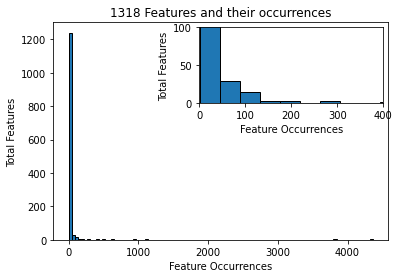

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

# Plot histogram
plt.hist(all_features.values(), bins=100, edgecolor='black')
plt.xlabel('Feature Occurrences')
plt.ylabel('Total Features')
plt.title(f'{len(all_features)} Features and their occurrences')

# Define the region of interest (bounding box)
x1, x2 = 0, 400  # Define the range of x-axis values for the zoomed-in plot
y1, y2 = 0, 100  # Define the range of y-axis values for the zoomed-in plot

# Get the current axes
ax = plt.gca()

# Create a new inset axes within the original plot
ax_zoom = inset_axes(ax, width="55%", height="35%", loc='upper right')

# Plot the zoomed-in histogram within the inset axes
ax_zoom.hist(all_features.values(), bins=100, edgecolor='black')
ax_zoom.set_xlim(x1, x2)
ax_zoom.set_ylim(y1, y2)
ax_zoom.set_xlabel('Feature Occurrences')
ax_zoom.set_ylabel('Total Features')

plt.show()

#### Highly skewed towards left
To qualify for company's main features, the expectation is that it should atleast occur in 1% of total companies 

In [10]:
# Selecting threshold for filtering features: 1% of total companies
threshold = round(0.01 * len(companies))
threshold

56

In [11]:
potential_features = dict(filter(lambda x:x[1]>threshold, list(all_features.items())))
len(potential_features)

66

In [12]:
irrelevant_features = dict(filter(lambda x:x[1]<=threshold, list(all_features.items())))
len(irrelevant_features)

1252

#### We will manually verify later if any important features went in the irrelevant_features category

In [13]:
# sorted(irrelevant_features, key=lambda x:irrelevant_features.get(x), reverse=True)

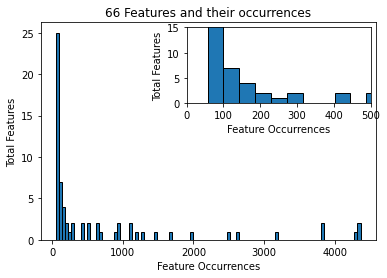

In [14]:
# Plot histogram
plt.hist(potential_features.values(), bins=100, edgecolor='black')
plt.xlabel('Feature Occurrences')
plt.ylabel('Total Features')
plt.title(f'{len(potential_features)} Features and their occurrences')

# Define the region of interest (bounding box)
x1, x2 = 0, 500  # Define the range of x-axis values for the zoomed-in plot
y1, y2 = 0, 15  # Define the range of y-axis values for the zoomed-in plot

# Get the current axes
ax = plt.gca()

# Create a new inset axes within the original plot
ax_zoom = inset_axes(ax, width="55%", height="35%", loc='upper right')

# Plot the zoomed-in histogram within the inset axes
ax_zoom.hist(potential_features.values(), bins=100, edgecolor='black')
ax_zoom.set_xlim(x1, x2)
ax_zoom.set_ylim(y1, y2)
ax_zoom.set_xlabel('Feature Occurrences')
ax_zoom.set_ylabel('Total Features')

plt.show()

#### Dividing 66 potential_features into two bucket, extra_features (less important) and selected_features (more relevant)

In [15]:
# Find the median, will use this to filter more features (which can be stored in `extra_features`)
median_value = np.median(list(potential_features.values()))
print("Median:", median_value)

Median: 169.5


In [16]:
selected_features = dict(filter(lambda x:x[1]>median_value, list(potential_features.items())))
len(selected_features)

33

In [17]:
extra_features = dict(filter(lambda x:x[1]<=median_value, list(potential_features.items())))
len(extra_features)

33

### Cleaning & Extracting selected_features

In [18]:
selected_features

{'Type': 3842,
 'Traded as': 1279,
 'Industry': 3818,
 'Founded': 4359,
 'Founders': 618,
 'Headquarters': 4366,
 'Area served': 1468,
 'Key people': 3196,
 'Products': 2627,
 'Revenue': 1966,
 'Parent': 1127,
 'Website': 4289,
 'Predecessor': 274,
 'Founder': 1678,
 'Fate': 408,
 'Location': 199,
 'Operating income': 946,
 'Net income': 1194,
 'Total assets': 1105,
 'Total equity': 944,
 'Number of employees': 2498,
 'Trade name': 271,
 'Formerly': 507,
 'Defunct': 419,
 'Successor': 185,
 'Owner': 674,
 'Services': 514,
 'Brands': 172,
 'Genre': 195,
 'Number of locations': 884,
 'Subsidiaries': 653,
 'Divisions': 287,
 'ISIN': 174}

In [19]:
selected_features.keys()

dict_keys(['Type', 'Traded as', 'Industry', 'Founded', 'Founders', 'Headquarters', 'Area served', 'Key people', 'Products', 'Revenue', 'Parent', 'Website', 'Predecessor', 'Founder', 'Fate', 'Location', 'Operating income', 'Net income', 'Total assets', 'Total equity', 'Number of employees', 'Trade name', 'Formerly', 'Defunct', 'Successor', 'Owner', 'Services', 'Brands', 'Genre', 'Number of locations', 'Subsidiaries', 'Divisions', 'ISIN'])

In [20]:
clean_companies_df = pd.DataFrame(clean_companies).T

In [21]:
selected_features_df = clean_companies_df[selected_features.keys()].dropna(how='all').dropna(how='all', axis=1)

In [22]:
def compare_columns(s1, s2):
    temp_df = pd.DataFrame([s1.dropna(),s2.dropna()]).T
    temp_df.columns = ["old", "new"]
    return temp_df.dropna(how='all').sample(10)

In [23]:
output_df = pd.DataFrame(index=selected_features_df.index)

### Cleaning Website and extracting domains

In [24]:
registrantNameDomainPattern = re.compile(r"((?:[a-z0-9](?:[a-z0-9-]{0,61}[a-z0-9])?\.)+[a-z0-9][a-z0-9-]{0,61}[a-z])")

def clean_domain(url):
    # Clean URL
    url = url.lower().strip('"').strip("'").strip()
    if ' ' in url: 
        url = ''.join(url.split(' '))
        
    # Remove leading "http://" or "https://"
    url = re.sub(r'.*http?s?://', '', url)
    
    # Remove leading "www." or anything before "www."
    url = re.sub(r'.*www\.', '', url)
    
    # Remove any additional paths or parameters after the main domain
    url = re.sub(r'/.*$', '', url)
    
    # Remove any `.` in the end or beginning of URL
    url = url.strip('.')
    
    # Remove any additional text after the top level domain
    # More items can be added using Public Suffix List
    url = re.sub(r'\.com.*$', '.com', url)
    url = re.sub(r'\.net.*$', '.net', url)
    url = re.sub(r'\.gov.*$', '.gov', url)
    url = re.sub(r'\.org.*$', '.org', url)
    url = re.sub(r'\.edu.*$', '.edu', url)
    url = re.sub(r'\.mil.*$', '.mil', url)

    # Remove any url that doesn't contain `.`
    url = '' if '.' not in url else url
    
    # Match the regex pattern
    match = registrantNameDomainPattern.search(url)
    url = match.group(1) if match else url
    
    return url

output_df["Website"] = selected_features_df["Website"].dropna().apply(lambda x:clean_domain(''.join(x)))

In [25]:
compare_columns(selected_features_df["Website"], output_df["Website"])

,old,new
"Robesonia,_Pennsylvania","[www, .robesoniaboro, .org]",robesoniaboro.org
Biomet,[www.biomet.com],biomet.com
Bovis_Lend_Lease,"[www, .lendlease, .com]",lendlease.com
"Sharonville,_Ohio","[www, .sharonville, .org]",sharonville.org
BAE_Systems_Customer_Solutions,[www.baesystems.com],baesystems.com
Campbell_Ewald,"[www, .c-e, .com]",c-e.com
Columbia_Sportswear,[www.columbia.com],columbia.com
APS_Payroll,"[www, .apspayroll, .com]",apspayroll.com
WORX,"[www, .worx, .com]",worx.com
Terrible_Herbst,"[www, .terribleherbst, .com]",terribleherbst.com


### Cleaning columns
* Type
* Parent
* Founded
* Traded As
* Defunct
* Fate

In [26]:
clean_boxes = lambda s: re.sub(r'\[\d\]', '', s)

In [27]:
clean_type = lambda x: [word.strip() for word in x.split(',') if re.findall(r'\b\w+ ?\b',re.sub(r'\(.*\)','',word))]
output_df["Type"] = selected_features_df["Type"].dropna().apply(lambda x:' '.join(clean_type(','.join(x))).strip()).apply(lambda x:clean_boxes(x))

In [28]:
compare_columns(selected_features_df["Type"], output_df["Type"])

,old,new
Reser%27s_Fine_Foods,[Private],Private
SAS_Institute,[Private],Private
Hennepin_County_Medical_Center,[Teaching],Teaching
Ralph_Lauren_Corporation,[Public],Public
Central_Market_(Texas),[Division],Division
USANA_Health_Sciences,[Public],Public
Deluxe_Corporation,[Public],Public
Hawaii_National_Bank,[Private],Private
Moderna,[Public],Public
APriori_Capital_Partners,[Private],Private


In [29]:
clean_parent = lambda x: [clean_boxes(word.strip()) for word in x.split(',') if re.findall(r'\b\w+ ?\b',re.sub(r'\(.*\)|\bLLC\b|\bInc.?\b|\bLtd.?\b|\band\b|\bIndependent\b','',word))]
output_df["Parent"] = selected_features_df["Parent"].dropna().apply(lambda x:clean_parent(','.join(x)))

In [30]:
compare_columns(selected_features_df["Parent"], output_df["Parent"])

,old,new
"Dell,_Inc.",[Dell Technologies],[Dell Technologies]
Warner_Bros.,[Warner Bros. Discovery],[Warner Bros. Discovery]
Malheur_Bell,"[Rocky Mountain Bell, , MST&T/US West/Qwest, ]","[Rocky Mountain Bell, MST&T/US West/Qwest]"
Jackson_National_Life,[Prudential plc],[Prudential plc]
Shire_Pharmaceuticals,"[Takeda Pharmaceutical Company, ]",[Takeda Pharmaceutical Company]
Kenexa_Corporation,[IBM],[IBM]
AmTran,"[Navistar International, ]",[Navistar International]
Ludwig_Drums,[Conn-Selmer],[Conn-Selmer]
Tecumseh_Products,"[Mueller Industries, , Atlas Holdings]","[Mueller Industries, Atlas Holdings]"
Panda_Inn,[Panda Restaurant Group],[Panda Restaurant Group]


In [31]:
def extract_year(text):
    match = re.search(r'\b\d{4}\b', text)
    return str(match.group()) if match else ''

output_df["Founded"] = selected_features_df["Founded"].dropna().apply(lambda x:extract_year(','.join(x)))

In [32]:
compare_columns(selected_features_df["Founded"], output_df["Founded"])

,old,new
"HCA_Holdings,_Inc.","[1968, ; 55 years ago, , 1968, , Nashville, Te...",1968
Axalta_Coating_Systems,"[1866, ; 157 years ago, , 1866, ]",1866
Space_Coast_Credit_Union,[1951],1951
PooPrints,"[2008, ; 15 years ago, , 2008, , in, Knoxville...",2008
Loud_Brothers,[1822],1822
Rick%27s_Picks,"[2004, , 2004, , in, Brooklyn, New York, , US]",2004
BE%26K,[1972],1972
Invacare,"[1885, ; 138 years ago, , 1885, ]",1885
The_Brink%27s_Company,"[1859, ; 164 years ago, , 1859, ]",1859
Aimco,"[1975 (as ""The Considine Company, Inc."", 1994 ...",1975


In [33]:
def get_ticker(tickers):
    filters = ["TSX", "ASX", "AMEX", "SIX", "FWB", "LSE", "OTCQB", "TYO", "NASDAQ", 'TOPIX', 'NAG']
    for i in tickers:
        items = re.findall(r'\b[A-Z]+\b', i)
        if items:
            ticker = items[0]
            if ticker not in filters:
                return clean_boxes(ticker)

output_df["Ticker"] = selected_features_df["Traded as"].dropna().apply(lambda x:get_ticker(x))

In [34]:
compare_columns(selected_features_df["Traded as"], output_df["Ticker"])

,old,new
Cathay_Bank,"[, :, CATY, Component]",CATY
Knoll_(company),"[, :, MLKN, , ]",MLKN
Mastercard,"[, :, MA, (Class A), , , , ]",MA
Waste_Connections,"[TSX, :, WCN, /TSX 60 ]",WCN
Frontier_Communications,"[, :, FYBR, , ]",FYBR
Deckers_Outdoor_Corporation,"[, :, DECK, , Component]",DECK
United_Technologies,"[, : UTX]",UTX
Sabre_Corporation,"[, :, SABR, , ]",SABR
Diamondback_Energy,"[, :, FANG, , , , ]",FANG
UnitedHealth_Group,"[, :, UNH, DJIA, , , , , ]",UNH


In [35]:
temp = selected_features_df["Defunct"].combine_first(selected_features_df["Fate"]).dropna().index
selected_features_df.loc[temp, 'is_defunct'] = True

output_df['is_defunct'] = selected_features_df['is_defunct']

### Extracting HQ information

In [36]:
def clean_headquarters(components):
    if isinstance(components, list):
        cleaned_components = [re.sub(r'[^a-zA-Z\s,]', '', str(comp)).strip() for comp in components]
        cleaned_components = [clean_boxes(comp) for comp in cleaned_components if comp]
        return ','.join(cleaned_components).replace(',,',',').replace(r',',', ').replace(r',  ',', ')
    else:
        return components
    
selected_features_df["HQ"] = selected_features_df["Headquarters"].dropna().apply(clean_headquarters)

In [37]:
with open("US cities.txt") as f:
    us_data = f.read()
    
us_data_df = pd.DataFrame(', '.join(us_data.split('\t')).split('\n'))
us_data_df.columns = ["US cities"]
us_data_df = pd.DataFrame(us_data_df["US cities"].apply(lambda x:x.split(',')).tolist())
us_data_df[2] = us_data_df[2].str.replace('-','').str.strip()
us_data_df[3] = us_data_df[3].str.strip()

us_cities = set(us_data_df[2].str.replace('-','').str.strip().dropna())

In [38]:
us_states_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MH': 'Marshall Islands', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

In [39]:
us_cities_dict = us_data_df.groupby(3)[2].apply(lambda x: set(x)).to_dict()

In [40]:
state_pattern = '|'.join(sorted(us_states_dict.values(), key=len, reverse=True))
state_regex = re.compile(rf'({state_pattern})', re.IGNORECASE)

state_shortname_pattern = '|'.join(sorted(us_states_dict.keys(), key=len, reverse=True))
state_shortname_regex = re.compile(rf'({state_shortname_pattern})')

city_pattern = r'\b|\b'.join(sorted(us_cities, key=len, reverse=True))
city_regex = re.compile(rf'({city_pattern})')

In [41]:
selected_features_df["HQ State"] = selected_features_df["HQ"].dropna().apply(lambda x:state_regex.search(x).group(0) if state_regex.search(x) else None)

empty_hq_state_index = selected_features_df["HQ State"].loc[selected_features_df["HQ State"].isnull()].index
empty_hq_state = selected_features_df["HQ"].loc[empty_hq_state_index].dropna()
selected_features_df["HQ Short State"] = empty_hq_state.apply(lambda x:us_states_dict.get(state_shortname_regex.search(x).group(0) if state_shortname_regex.search(x) else None)).dropna()

selected_features_df["HQ State"] = selected_features_df["HQ State"].combine_first(selected_features_df["HQ Short State"]).dropna()

In [42]:
selected_features_df["HQ City"] = selected_features_df["HQ"].dropna().apply(lambda x:city_regex.search(x).group(0) if city_regex.search(x) else None)

In [43]:
def get_city(state, city, us_cities_dict):
    cities = us_cities_dict.get(state, set())
    return True if city in cities else False

def get_alt_city_state(state, alt_cities, alt_states, us_cities_dict, default = "city"):
    
    def _check_city():
        cities = us_cities_dict.get(state, set())
        if isinstance(alt_cities, list):
            for city in alt_cities[::-1]:
                if city in cities:
                    return city if default == "city" else state
    
    _check_city()
    if isinstance(alt_states, set):
        for state in alt_states-{state}:
            _check_city()

In [44]:
temp_df = selected_features_df[["HQ", "HQ City", "HQ State"]].dropna(how='all')

temp_df["IsCityInState"] = temp_df.apply(lambda row: get_city(row["HQ State"], row["HQ City"], us_cities_dict), axis=1)
wrong_cities_index = (temp_df.loc[temp_df["IsCityInState"] == False]).index

temp_df["Alternative Cities"] = temp_df.loc[wrong_cities_index]["HQ"].dropna().apply(lambda x:re.findall(city_regex, x) if city_regex.search(x) else None)

alt_states = temp_df["HQ"].dropna().apply(lambda x:set(re.findall(state_regex, x)) if state_regex.search(x) else None).dropna()
temp_df["Alternative States"] = alt_states.loc[alt_states.apply(lambda x:len(x))>1]

temp_df["Alt City"] = temp_df.apply(lambda row: get_alt_city_state(row["HQ State"], row["Alternative Cities"], row["Alternative States"], us_cities_dict, default = "city"), axis=1)
temp_df["Alt State"] = temp_df.apply(lambda row: get_alt_city_state(row["HQ State"], row["Alternative Cities"], row["Alternative States"], us_cities_dict, default = "state"), axis=1)

temp_df["IsAltCityInAltState"] = temp_df.apply(lambda row: get_city(row["Alt State"], row["Alt City"], us_cities_dict), axis=1)


In [45]:
# Possible Wrong mappings of either City or State from HQ
temp_df.loc[(temp_df["IsCityInState"]==False) & (temp_df["IsAltCityInAltState"]==False)].sample(5)#.loc["Red_Robin"]["HQ"]

,HQ,HQ City,HQ State,IsCityInState,Alternative Cities,Alternative States,Alt City,Alt State,IsAltCityInAltState
FedEx,"S Shady Grove Rd, Memphis, Tennessee, US",Shady Grove,Tennessee,False,"[Shady Grove, Memphis, Tennessee]",NaN,None,None,False
Valpak,"St Petersburg, Florida, US",Petersburg,Florida,False,"[Petersburg, Florida]",NaN,None,None,False
Woolrich,"Bologna, Italy",Italy,NaN,False,[Italy],NaN,None,None,False
G1_Therapeutics,"North Carolina, United States",North,North Carolina,False,"[North, Carolina, United]",NaN,None,None,False
Randall_Made_Knives,"S Orange Blossom Trail, Orlando, Florida",Orange,Florida,False,"[Orange, Blossom, Trail, Orlando, Florida]",NaN,None,None,False


In [46]:
temp_df["Alt City"] = temp_df["Alt City"].combine_first(temp_df["HQ City"]).dropna()
temp_df["Alt State"] = temp_df["Alt State"].combine_first(temp_df["HQ State"]).dropna()

selected_features_df["HQ State"] = temp_df["Alt State"]
selected_features_df["HQ City"] = temp_df["Alt City"]

In [47]:
selected_features_df[["Headquarters","HQ", "HQ City", "HQ State"]].dropna(how='all').sample(5)

,Headquarters,HQ,HQ City,HQ State
Venafi,"[Salt Lake City, UT, , United States]","Salt Lake City, UT, United States",Salt Lake City,Utah
PricewaterhouseCoopers,"[London, , England]","London, England",London,NaN
704Games,"[Charlotte, , North Carolina, , United States]","Charlotte, North Carolina, United States",Charlotte,North Carolina
Argon_ST,"[Fairfax, Virginia, , United States]","Fairfax, Virginia, United States",Fairfax,Virginia
The_Reynolds_and_Reynolds_Company,"[1 Reynolds Way, Dayton, Ohio, , U.S.]","Reynolds Way, Dayton, Ohio, US",Reynolds,Ohio


In [48]:
output_df["HQ"] = selected_features_df["HQ"]
output_df["HQ State"] = selected_features_df["HQ State"]
output_df["HQ City"] = selected_features_df["HQ City"]                                       

### Transforming columns 'Total equity', 'Total assets', 'Net income', 'Operating income', 'Revenue' into `"Net Worth"`

In [49]:
def filter_net_worth(df, col):
    pattern = r'(?i)(?:(?P<us>\bUSD?\s?)?[$]?\s?((?P<int>[0-9,]+[.])?[0-9,]+)(\s?(?P<unit>[MBbT]illion))?)'
    temp_df = df.loc[(df["Processed"].isnull()) | (df["Processed"]=='e')][col].dropna().apply(lambda x:''.join(x)).str.extract(pattern, expand=True)
    temp_df.loc[(temp_df['unit']=='billion') | (temp_df['unit']=='Billion'), "Processed"] = 'b'
    temp_df.loc[(temp_df['unit']=='million') | (temp_df['unit']=='Million'), "Processed"] = 'm'
    temp_df.loc[temp_df['unit'].isnull(), "Processed"] = "e"
    processed_companies = set(temp_df.index)
    df.loc[list(processed_companies), "Processed"] = temp_df["Processed"]
    return df

In [50]:
def _get_net_worth_category(revenue_size):    
    if 0 < revenue_size <= 1 :
        return 'Micro ($0-$1MM)'
    elif 1  < revenue_size <= 10 :
        return 'Small ($1MM-$10MM)'
    elif 10  < revenue_size <= 50 :
        return 'Medium-Small ($10MM- $50MM)'
    elif 50  < revenue_size <= 100 :
        return 'Medium-Large ($50MM-$100MM)'
    elif 100  < revenue_size <= 200 :
        return 'Large ($100MM-$200MM)'
    elif 200  < revenue_size <= 1000 :
        return 'XLarge ($200MM-$1B)'
    elif revenue_size > 1000 :
        return 'XXLarge ($1B+)'


def extract_net_worth(df, col):
    pattern = r'(?i)(?:(?P<us>\bUSD?\s?)?[$]?\s?((?P<int>[0-9,]+[.])?[0-9,]+)(\s?(?P<unit>[MBbT]illion))?)'
    temp_df = df.loc[(df["Processed"]=='m')][col].dropna().apply(lambda x:''.join(x)).str.extract(pattern, expand=True)
    temp_df['Net Worth'] = temp_df[1].apply(lambda x: ''.join(x.split(',')).split('.')[0].strip() if isinstance(x, str) else '').apply(lambda x: _get_net_worth_category(int(x) if x else 0))
    processed_companies = set(temp_df.index)
    df.loc[list(processed_companies), "Net Worth"] = temp_df["Net Worth"]
    return df

In [51]:
temp_df = selected_features_df[["Total assets", 'Total equity', 'Net income', 'Operating income', 'Revenue']][:]
temp_df['Processed'] = None

temp_df = filter_net_worth(temp_df, col = 'Total assets')
temp_df = filter_net_worth(temp_df, col = 'Total equity')
temp_df = filter_net_worth(temp_df, col = 'Revenue')
temp_df = filter_net_worth(temp_df, col = 'Operating income')
temp_df = filter_net_worth(temp_df, col = 'Net income')


temp_df.loc[temp_df['Processed']=='b', 'Net Worth'] = "XXLarge ($1B+)"
temp_df = extract_net_worth(temp_df, col = 'Total assets')
temp_df = extract_net_worth(temp_df, col = 'Total equity')
temp_df = extract_net_worth(temp_df, col = 'Revenue')

In [52]:
# Not processing records with category 'e'

# temp_df.loc[(temp_df['Processed']=='e')].dropna(how='all')['Total assets'].dropna()

In [53]:
selected_features_df["Net Worth"] = temp_df["Net Worth"]
output_df["Net Worth"] = selected_features_df["Net Worth"]

In [54]:
output_df['Net Worth'].value_counts()

XXLarge ($1B+)                 1472
XLarge ($200MM-$1B)             268
Large ($100MM-$200MM)            69
Medium-Large ($50MM-$100MM)      40
Medium-Small ($10MM- $50MM)      39
Small ($1MM-$10MM)               25
Micro ($0-$1MM)                  15
Name: Net Worth, dtype: int64

In [55]:
selected_features_df[["Total assets", 'Total equity', 'Net income', 'Operating income', 'Revenue', "Net Worth"]].dropna(how='all').sample(5)

,Total assets,Total equity,Net income,Operating income,Revenue,Net Worth
Applied_Micro_Circuits_Corporation,"[US$, 316 million, , FY 2010, , ]","[US$, 281 million, , FY 2010, , ]","[US$, -7.49 million, , FY 2010, , ]","[US$, -26.1 million, , FY 2010, , ]","[US$, 206 million, , FY 2010, , ]",XLarge ($200MM-$1B)
RingCentral,"[, US$2.07 billion, ]","[, US$−483 million, ]","[, US$−879 million, ]","[, US$−649 million, ]","[, US$, 1.99 billion, ]",XXLarge ($1B+)
Beckman_Coulter,"[US$, 4.88B, , FY 2010, , ]","[US$, 2.13B, , FY 2010, , ]","[US$, 231M, , FY 2010, , ]","[US$, 405M, , FY 2010, , ]","[US$, 3.66B, , FY 2010, , ]",NaN
Oath_Inc.,NaN,NaN,NaN,NaN,"[$7.4 billion , ]",XXLarge ($1B+)
Quanta_Services,NaN,NaN,NaN,NaN,"[$9.466 billion, USD, , ]",XXLarge ($1B+)


### Transforming Columns
* Industry, Genre -> Industry
* Products, Services, Brands -> Products_and_Services
* Subsidiaries, Divisions -> Subsidiaries
* Successor, Formerly, Trade name, Predecessor -> Aliases
* Founders, Founder, Key people, Owner -> People

In [56]:
def combine_series_with_lists(series1, series2):
    """
    Combine two Pandas Series element-wise, where each element is a list.

    Parameters:
    - series1 (pd.Series): The first input Series.
    - series2 (pd.Series): The second input Series.

    Returns:
    - pd.Series: A new Series where each element is a combined list from the input Series.
    """

    # Function to combine lists from two Series elements
    def combine_lists(x, y):
        if isinstance(x, list) and isinstance(y, list):
            return x + y
        elif isinstance(x, list):
            return x
        elif isinstance(y, list):
            return y
        return []

    # Apply combine_lists to the input Series
    combined_series = series1.combine(series2, lambda x, y: combine_lists(x, y))

    # Replace empty lists with NaN values
    combined_series = combined_series.apply(lambda x: np.nan if (x is None or x == []) else x)

    return combined_series

In [57]:
temp = combine_series_with_lists(selected_features_df['Industry'], selected_features_df['Genre'])
temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
output_df["Industry"] = temp.apply(lambda x: [clean_boxes(item) for item in x])

In [58]:
temp = combine_series_with_lists(selected_features_df['Products'], selected_features_df['Services'])
temp = combine_series_with_lists(temp, selected_features_df['Brands'])
temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
output_df["Products_and_Services"] = temp

In [59]:
temp = combine_series_with_lists(selected_features_df['Subsidiaries'], selected_features_df['Divisions'])
temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
output_df["Subsidiaries"] = temp

In [60]:
temp = combine_series_with_lists(selected_features_df['Successor'], selected_features_df['Formerly'])
temp = combine_series_with_lists(temp, selected_features_df['Trade name'])
temp = combine_series_with_lists(temp, selected_features_df['Predecessor'])
temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
output_df["Aliases"] = temp

In [61]:
temp = combine_series_with_lists(selected_features_df['Founders'], selected_features_df['Founder'])
temp = combine_series_with_lists(temp, selected_features_df['Key people'])
temp = combine_series_with_lists(temp, selected_features_df['Owner'])
temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
output_df["People"] = temp

In [62]:
# temp = combine_series_with_lists(selected_features_df['Number of locations'], selected_features_df['Area served'])
# temp = combine_series_with_lists(temp, selected_features_df['Location'])
# temp = temp.dropna().apply(lambda x:set(x)-{'', ' '}).apply(lambda x: [clean_boxes(item.strip().strip(',')) for item in x])
# output_df["Locations"] = temp

### Transforming `Number of Employees` into categories
- Micro (1-9 Employees) 
- Small (10-49 Employees)
- Medium-Small (50-199 Employees)
- Medium (200-499 Employees)
- Medium-Large (500-999 Employees)
- Large (1,000-4,999 Employees) 
- XLarge (5000-10,000 Employees)
- XXLarge (10,000+ Employees)

In [63]:
def get_employee_category(num_employees):
    if  1 <= num_employees <= 9:
        return 'Micro (1-9 Employees)'
    elif 10 <= num_employees <= 49:
        return 'Small (10-49 Employees)'
    elif 50 <= num_employees <= 199:
        return 'Medium-Small (50-199 Employees)'
    elif 200 <= num_employees <= 499:
        return 'Medium (200-499 Employees)'
    elif 500 <= num_employees <= 999:
        return 'Medium-Large (500-999 Employees)'
    elif 1000 <= num_employees <= 4999:
        return 'Large (1,000-4,999 Employees)'
    elif 5000 <= num_employees < 10000:
        return 'XLarge (5000-10,000 Employees)'
    elif num_employees >= 10000:
        return 'XXLarge (10,000+ Employees)'

def extract_numeric_and_convert(text):
    for item in text:
        numeric = re.findall(r'([\d ,]+)', item)  # Remove non-numeric characters
        if numeric:
            for each in numeric:
                split_numeric=each.strip(',').strip().split()
                if split_numeric:
                    for i in split_numeric:
                        out = i.strip(',').strip()
                        return out

In [64]:
temp = selected_features_df['Number of employees'].dropna()
temp = temp.apply(extract_numeric_and_convert)
temp = temp.apply(lambda x:int(''.join(x.split(','))) if x else np.nan)
temp = temp.dropna().apply(lambda x:get_employee_category(x))

output_df['Number of employees'] = temp

In [65]:
compare_columns(selected_features_df['Number of employees'], output_df['Number of employees'])

,old,new
Christopherson_Business_Travel,[480 ],Medium (200-499 Employees)
Boeing,"[156,000 ]","XXLarge (10,000+ Employees)"
Acuity_Brands,"[11,500, , ]","XXLarge (10,000+ Employees)"
Waymo,"[2,500 ]","Large (1,000-4,999 Employees)"
Northrop_Grumman,"[c., 95,000, ]","XXLarge (10,000+ Employees)"
Syneos_Health,"[28,000 ]","XXLarge (10,000+ Employees)"
Idaho_Power,"[1,976 full time employees , ]","Large (1,000-4,999 Employees)"
Gemini_Group,"[2,700+]","Large (1,000-4,999 Employees)"
Carolina_Foods,[425 ],Medium (200-499 Employees)
La_Quinta_Inns_%26_Suites,[9000],"XLarge (5000-10,000 Employees)"


### Final Output

In [66]:
output_df = output_df.dropna(how='all').dropna(how='all',axis=1)

output_df.index = pd.Series(output_df.index.values).apply(lambda x:' '.join(x.split('_')))

output_df.columns

Index(['Website', 'Type', 'Parent', 'Founded', 'Ticker', 'is_defunct', 'HQ',
       'HQ State', 'HQ City', 'Net Worth', 'Industry', 'Products_and_Services',
       'Subsidiaries', 'Aliases', 'People', 'Number of employees'],
      dtype='object')

In [67]:
output_df.sample(5)

,Website,Type,Parent,Founded,Ticker,is_defunct,HQ,HQ State,HQ City,Net Worth,Industry,Products_and_Services,Subsidiaries,Aliases,People,Number of employees
Datacard Group,entrust.com,Private,NaN,1994,NaN,NaN,"Minneapolis, MN, United States",Minnesota,Minneapolis,NaN,[Digital Security and Credential Issuance],"[Digital Certificates, Digital Signing, Public...",NaN,[Entrust Datacard],NaN,"Large (1,000-4,999 Employees)"
Towerstream,towerstream.com,Public,NaN,1999,TWER,NaN,"Hammarlund Way Tech III, Middletown, Rhode Isl...",Rhode Island,Middletown,NaN,[Telecommunications],NaN,NaN,NaN,"[Philip Urso, Jeffrey Thompson]",NaN
RFPIO,rfpio.com,Privately Held,NaN,2015,NaN,NaN,"Beaverton, Oregon",Oregon,Beaverton,NaN,"[Software, Cloud Computing -]","[RFP360, RFPIO, RFPIO Lookup, Cloud-based requ...",NaN,NaN,"[Ganesh Shankar, ; AJ Sunder, CIO; Sankar Lagu...",Medium (200-499 Employees)
Texas Precious Metals,texmetals.com,Private,NaN,2011,NaN,NaN,"Shiner, Texas, United States",Texas,Shiner,NaN,[Precious metals],"[bars, Silver coins, Gold coins]",NaN,NaN,"[Tarek Saab, & Co-founder\nJason Kaspar, Co-...",NaN
Champlin Architecture,thinkchamplin.com,NaN,NaN,1978,NaN,NaN,NaN,NaN,NaN,NaN,[Architecture],"[Structural Engineering, Planning, Interior D...",NaN,NaN,"[Michael J. Battoclette, Robert A. Schilling, ...",NaN


In [68]:
output_df.to_csv('WikiCompanies.csv')

## TODO: Examine more features from `extra_features`

In [69]:
extra_features.keys()

dict_keys(['Coordinates', 'AUM', 'Production output', 'Areas served', 'IATA', 'Hubs', 'Fleet size', 'Parent company', 'Area', 'Owners', 'Country', 'State', 'County', 'Government', '•\xa0Total', '•\xa0Land', '•\xa0Water', 'Population', '•\xa0Density', 'Time zone', '•\xa0Summer ', 'Area code', 'FIPS code', 'Ceased operations', 'URL', 'Country of origin', 'Official website', 'Predecessors', 'Elevation', 'Destinations', 'Employees', 'Opened', ''])

In [70]:
extra_features_df = clean_companies_df[extra_features.keys()].dropna(how='all').dropna(how='all', axis=1)
extra_features_df.sample(5)

,Coordinates,AUM,Production output,Areas served,IATA,Hubs,Fleet size,Parent company,Area,Owners,...,Ceased operations,URL,Country of origin,Official website,Predecessors,Elevation,Destinations,Employees,Opened,
Los_Angeles_Airways,NaN,NaN,NaN,NaN,NaN,"[Westchester, , Los Angeles]",NaN,NaN,NaN,NaN,...,[1971],NaN,NaN,NaN,NaN,NaN,"[Disneyland, , Newporter Resort, Los Angeles a...",NaN,NaN,NaN
The_Daily_Voice_(U.S._hyperlocal_news),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"[dailyvoice, .com]",NaN,NaN,NaN,NaN,NaN,"[44 (mid-2010), 100 (mid-2012)]",NaN,NaN
Beyond_Words_Publishing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[United States],[www.beyondword.com],NaN,NaN,NaN,NaN,NaN,NaN
Gulfstream_International_Airlines,NaN,NaN,NaN,NaN,[],NaN,[24],NaN,NaN,NaN,...,[November 2010],NaN,NaN,NaN,NaN,NaN,[3],NaN,NaN,NaN
SeaPort_Airlines,NaN,NaN,NaN,NaN,[],"[Portland International Airport, Memphis Inter...",NaN,"[SeaPort Airlines, Inc.]",NaN,NaN,...,"[September 20, 2016]",NaN,NaN,NaN,NaN,NaN,[7],NaN,NaN,NaN
